In [1]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time

# eq = desc.examples.get("DSHAPE")
eq = desc.io.load("equilibria/test_run.h5")
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

def B_for_f_ratio_surface(psi_i):
    grid = LinearGrid(rho = np.sqrt(psi_i), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    return B

def B_for_f_ratio_fieldline(psi_i):
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(psi_i))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))




DESC version 0+untagged.5512.gd5ef3d2.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 3.72 GB available memory
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.734e-06
         Total delta_x: 6.469e-02
         Iterations: 5
         Function evaluations: 9
         Jacobian evaluations: 6
Start of solver
Total (sum of squares):  2.876e-06, 
Total force:  1.355e+05 (N)
Total force:  2.398e-03 (normalized)
End of solver
Total (sum of squares):  2.734e-06, 
Total force:  1.321e+05 (N)
Total force:  2.338e-03 (normalized)


In [2]:
def check(quantity, rho_i, theta_i, zeta_i):
    grid = Grid(jnp.array([rho_i, theta_i, zeta_i]).T, jitable=True, sort=False)
    output = eq.compute(quantity, grid=grid)
    return output[quantity]

# plot_3d(eq, "B")
val = check("grad(psi)", 1, 0, 0)[0]
print(val)

[ 1.57992279e+01 -3.24372694e-16  7.48118656e-16]


In [3]:
def system(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "b"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([jnp.sqrt(psi), theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    mu, m_q, bound_psi = a

    aux = data["b"] + m_q*(mu/data["|B|"]**2) * jnp.cross(data["B"], data["grad(|B|)"], axis=-1)/vpar

    psidot = m_q*(1/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])  
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + (m_q/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^zeta"]) 
    vpardot = -mu*jnp.sum(aux * data["grad(|B|)"], axis=-1)

    return jnp.array([psidot/bound_psi, thetadot, zetadot, vpardot])

In [4]:
def run(E, charge, bound_psi, m, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    tmin = t_i
    tmax = t_f
    nt = nt_
    m_q = m/charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    
    grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
    data = eq.compute("|B|", grid=grid)

    mu = E/(m*data["|B|"]) - (v_parallel**2)/(2*data["|B|"])
    a_initial = [float(mu), m_q, bound_psi]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]
    print(a_initial)

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(system)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol, mu

In [5]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 0.00007
nt_ = 50

charge = q_*1.6e-19
m = m_*1.673e-27
E = E_*3.52e6*charge
m_q = m/charge

psi_i = 0.7
theta_i = 0.2
zeta_i = 0.2
bound_psi = check("psi", 1, theta_i, zeta_i)[0]

f = f_ratio(B_for_f_ratio_surface(psi_i=psi_i))

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.7*f
print(vpar_i_ratio)
sol, mu = run(E, charge, bound_psi, m, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

0.7 0.2 0.2
0.24074592089559968
[63419741148794.98, 1.0456250000000001e-08, 7.736976778455998]


2023-09-06 12:19:40.949559: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-06 12:21:03.076965: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m22.127721766s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 7.00000000e-01  2.00000000e-01  2.00000000e-01  6.24679549e+06]
 [ 6.88488535e-01  3.66073429e-01  6.62170030e-01  6.03759713e+06]
 [ 6.70550177e-01  5.30331392e-01  1.17727584e+00  5.77499933e+06]
 [ 6.46811221e-01  7.53865270e-01  1.70847581e+00  5.35892100e+06]
 [ 6.18846554e-01  8.92335850e-01  2.17423757e+00  4.93673472e+06]
 [ 5.88405785e-01  1.04188648e+00  2.54936206e+00  4.45094338e+06]
 [ 5.56842646e-01  1.15407293e+00  2.85168900e+00  3.85638160e+06]
 [ 5.24704747e-01  1.29501860e+00  3.09915275e+00  3.13179598e+06]
 [ 4.92010823e-01  1.40703520e+00  3.30283050e+00  2.40369882e+06]
 [ 4.59327002e-01  1.46175751e+00  3.45929337e+00  1.80845550e+06]
 [ 4.27242487e-01  1.50226376e+00  3.57996948e+00  1.17341557e+06]
 [ 3.96089317e-01  1.52273121e+00  3.64280791e+00  3.71519558e+05]
 [ 3.66096989e-01  1.52020294e+00  3.64296081e+00 -3.63906836e+05]
 [ 3.37353997e-01  1.49510445e+00  3.58279992e+00 -1.11090850e+06]
 [ 3.10056001e-01  1.44911792e+00  3.47071720e+00 -1.66732486e

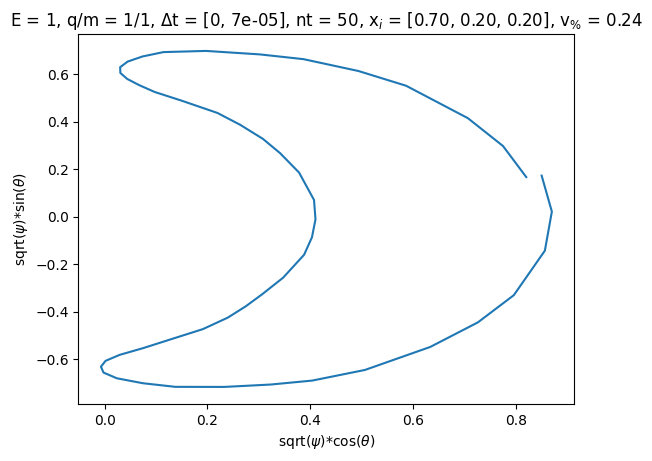

In [11]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q/m = {q_}/{m_}, $\Delta$t = [{t_i}, {t_f}], nt = {nt_}, x$_i$ = [{psi_i:.2f}, {theta_i:.2f}, {zeta_i:.2f}], v$_\%$ = {vpar_i_ratio:.2f}')
plt.show()

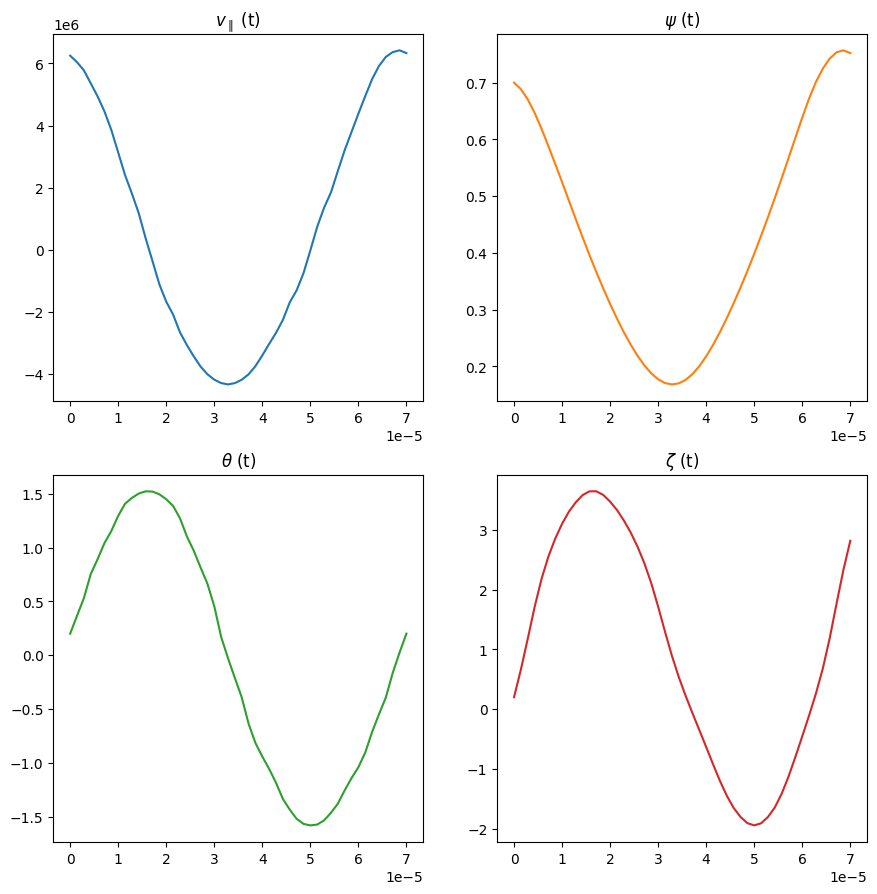

In [12]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(t, sol[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

[5.63200000e-13 5.63199282e-13 5.63199317e-13 5.63198699e-13
 5.63198202e-13 5.63199478e-13 5.63196205e-13 5.63195668e-13
 5.63194540e-13 5.63190996e-13 5.63187575e-13 5.63181698e-13
 5.63176887e-13 5.63170988e-13 5.63167476e-13 5.63166140e-13
 5.63163756e-13 5.63169508e-13 5.63167968e-13 5.63166474e-13
 5.63166223e-13 5.63165913e-13 5.63165429e-13 5.63165365e-13
 5.63165510e-13 5.63165997e-13 5.63163814e-13 5.63164703e-13
 5.63167095e-13 5.63167463e-13 5.63167686e-13 5.63170063e-13
 5.63170416e-13 5.63173319e-13 5.63173744e-13 5.63172875e-13
 5.63172012e-13 5.63172338e-13 5.63175022e-13 5.63175617e-13
 5.63177392e-13 5.63177973e-13 5.63179316e-13 5.63180524e-13
 5.63179973e-13 5.63181781e-13 5.63181927e-13 5.63182176e-13
 5.63182085e-13 5.63181745e-13]


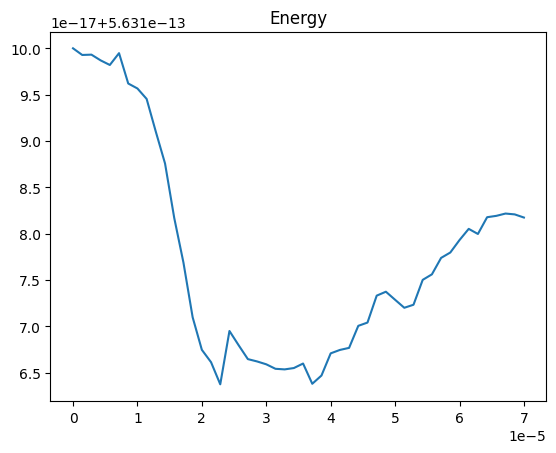

In [8]:

grid = Grid(np.vstack((np.sqrt(sol[:, 0]), sol[:, 1], sol[:, 2])).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(sol[:, 3]**2 + 2*B_field["|B|"]*mu)*m
plt.plot(t, Energy)
plt.title("Energy")
print(Energy)
Energy_i = 0.5*(2*mu*B_field["|B|"][0] + (vpar_i_ratio*jnp.sqrt(2*E/m))**2)*m

In [9]:
grid = Grid(np.vstack((np.sqrt(sol[:, 0]), sol[:, 1], sol[:, 2])).T,sort=False)
sys = eq.compute(["psidot", "thetadot", "zetadot", "vpardot"], grid=grid, mu = mu, vpar = sol[:, 3], m_q = 1.673e-27/1.6e-19)
print(sys["psidot"][-1])
local_sys = system([sol[-1, 0], sol[-1, 1], sol[-1, 2], sol[-1, 3]], t, [mu, 1.673e-27/1.6e-19, bound_psi])
print(local_sys[0])


-6287.620002874281
[-6287.62000287]


In [10]:
print(sys["thetadot"][-1])
print(local_sys[1])
print(sys["zetadot"][-1])
print(local_sys[2])
# print(sys["vpardot"][-1])
# print(local_sys[3])

125753.94833719611
[125753.9483372]
317074.71715314675
[317074.71715315]
